# Google Colab Rust Setup

The following cell is used to set up and spin up a Jupyter Notebook environment with a Rust kernel using Nix and IPC Proxy.

In [1]:
!wget -qO- https://gist.github.com/wiseaidev/2af6bef753d48565d11bcd478728c979/archive/3f6df40db09f3517ade41997b541b81f0976c12e.tar.gz | tar xvz --strip-components=1
!bash setup_evcxr_kernel.sh

2af6bef753d48565d11bcd478728c979-3f6df40db09f3517ade41997b541b81f0976c12e/setup_evcxr_kernel.sh
info: downloading installer
 INFO nix-installer v3.10.1
 INFO Step: Create directory `/nix`
 INFO Step: Provision Nix
 INFO Step: Create build users (UID 30001-30032) and group (GID 30000)
 INFO Step: Configure Nix
 INFO Step: Create directory `/etc/tmpfiles.d`
 INFO Step: Configure upstream Nix daemon service
 INFO Step: Remove directory `/nix/temp-install-dir`
 WARN SelfTest([ShellFailed { shell: Sh, command: "\"sh\" \"-lc\" \"exec nix build --option substitute false --option post-build-hook \\'\\' --no-link --expr \\'derivation { name = \\\"self-test-sh-1756884483853\\\"; system = \\\"x86_64-linux\\\"; builder = \\\"/bin/sh\\\"; args = [\\\"-c\\\" \\\"echo hello > \\\\$out\\\"]; }\\'\"", output: Output { status: ExitStatus(unix_wait_status(256)), stdout: "", stderr: "error:\n       … while calling the 'derivationStrict' builtin\n         at <nix/derivation-internal.nix>:37:12:\n          

---

# Tour of the EvCxR Jupyter Kernel
For those not already familiar with Jupyter notebook, it lets you write code into "cells" like the box below. Cells can alternatively contain markdown, like this text here. Each code cell is compiled and executed separately, but variables, defined functions etc persist between cells.

## Printing to outputs and evaluating expressions
Lets print something to stdout and stderr then return a final expression to see how that's presented. Note that stdout and stderr are separate streams, so may not appear in the same order is their respective print statements.

In [ ]:
println!("Hello world");
eprintln!("Hello error");
format!("Hello {}", "world")

Hello error


Hello world


"Hello world"

## Assigning and making use of variables
We define a variable `message`, then in the subsequent cell, modify the string and finally print it out. We could also do all this in the one cell if we wanted.

In [ ]:
let mut message = "Hello ".to_owned();

In [ ]:
message.push_str("world!");

In [ ]:
message

"Hello world!"

## Defining and redefining functions
Next we'll define a function

In [ ]:
pub fn fib(x: i32) -> i32 {
    if x <= 2 {0} else {fib(x - 2) + fib(x - 1)}
}

In [ ]:
(1..13).map(fib).collect::<Vec<i32>>()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Hmm, that doesn't look right. Lets redefine the function. In practice, we'd go back and edit the function above and reevalute it, but here, lets redefine it in a separate cell.

In [ ]:
pub fn fib(x: i32) -> i32 {
    if x <= 2 {1} else {fib(x - 2) + fib(x - 1)}
}

In [ ]:
let values = (1..13).map(fib).collect::<Vec<i32>>();
values

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

## Spawning a separate thread and communicating with it
We can spawn a thread to do stuff in the background, then continue executing code in other cells.

In [ ]:
use std::sync::{Mutex, Arc};
let counter = Arc::new(Mutex::new(0i32));
std::thread::spawn({
    let counter = Arc::clone(&counter);
    move || {
        for i in 1..300 {
            *counter.lock().unwrap() += 1;
            std::thread::sleep(std::time::Duration::from_millis(100));
        }
}});

In [ ]:
*counter.lock()?

65

In [ ]:
*counter.lock()?

120

## Loading external crates
We can load external crates. This one takes a while to compile, but once it's compiled, subsequent cells shouldn't need to recompile it, so it should be much quicker.

In [ ]:
:dep base64 = "0.10.1"
base64::encode(&vec![1, 2, 3, 4])

"AQIDBA=="

## Customizing how types are displayed
We can also customize how our types are displayed, including presenting them as HTML. Here's an example where we define a custom display function for a type `Matrix`.

In [ ]:
use std::fmt::Debug;
pub struct Matrix<T> {pub values: Vec<T>, pub row_size: usize}
impl<T: Debug> Matrix<T> {
    pub fn evcxr_display(&self) {
        let mut html = String::new();
        html.push_str("<table>");
        for r in 0..(self.values.len() / self.row_size) {
            html.push_str("<tr>");
            for c in 0..self.row_size {
                html.push_str("<td>");
                html.push_str(&format!("{:?}", self.values[r * self.row_size + c]));
                html.push_str("</td>");
            }
            html.push_str("</tr>");
        }
        html.push_str("</table>");
        println!("EVCXR_BEGIN_CONTENT text/html\n{}\nEVCXR_END_CONTENT", html);
    }
}

In [ ]:
let m = Matrix {values: vec![1,2,3,4,5,6,7,8,9], row_size: 3};
m

1,2,3
4,5,6
7,8,9


We can also return images using add-on crates like `evcxr_image`, which adds support for displaying RGB and grayscale images in Evcxr. Note, the version of the `image` crate used must match the version used by `evcxr_image`, otherwise the types will effectively be different and the image won't get displayed.

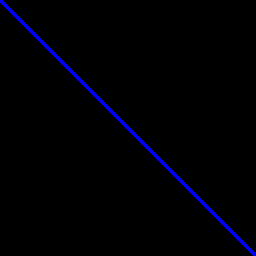

In [ ]:
:dep image = "0.23"
:dep evcxr_image = "1.1"
use evcxr_image::ImageDisplay;

image::ImageBuffer::from_fn(256, 256, |x, y| {
    if (x as i32 - y as i32).abs() < 3 {
        image::Rgb([0, 0, 255])
    } else {
        image::Rgb([0, 0, 0])
    }
})

## Display of compilation errors
Here's how compilation errors are presented. Here we forgot an & and passed a String instead of an &str.

In [ ]:
let mut s = String::new();
s.push_str(format!("foo {}", 42));

Error: mismatched types

## Async await
Async functions can be called and the results awaited. Currently this uses Tokio as the executor. The first run of code that uses await will likely be slow while Tokio is compiled. We explicitly add tokio as a dependency so that we can turn on the "full" feature. This is needed for TcpStream. This example also demostrates use of the question mark operator, which upon finding that the result contained an error, prints it to stderr.

In [ ]:
:dep tokio = {version = "0.2", features = ["full"]}

In [ ]:
let mut stream : tokio::net::TcpStream = tokio::net::TcpStream::connect("127.0.0.1:99999").await?;

invalid port value


Note, we needed to give an explicit type to the stream variable, because rustc, at least at the time of writing suggests `tokio::net::tcp::TcpStream`, which is private. We need to explicitly provide the public alias in such cases.

Now let's try again with a valid port number. First, make something listen on port 6543. You might be able to use netcat, e.g. `nc -t -l 6543`.

In [ ]:
let mut stream : tokio::net::TcpStream = tokio::net::TcpStream::connect("127.0.0.1:6543").await?;

In [ ]:
use tokio::io::AsyncWriteExt;
stream.write(b"Hello, world!\n").await?;

At this point, netcat, or whatever was listening on port 6543 should have received (and printed) "Hello, world!".

## Seeing what variables have been defined
We can print a table of defined variables and their types with the :vars command.

In [ ]:
:vars

Variable,Type
counter,std::sync::Arc<std::sync::Mutex<i32>>
message,String
m,user_code_13::Matrix<i32>
values,std::vec::Vec<i32>


Other built-in commands can be found via :help

In [ ]:
:help

:vars             List bound variables and their types
:opt [level]      Toggle/set optimization level
:fmt [format]     Set output formatter (default: {:?}). 
:explain          Print explanation of last error
:clear            Clear all state, keeping compilation cache
:dep              Add dependency. e.g. :dep regex = "1.0"
:sccache [0|1]    Set whether to use sccache.
:linker [linker]  Set/print linker. Supported: system, lld
:version          Print Evcxr version
:preserve_vars_on_panic [0|1]  Try to keep vars on panic

Mostly for development / debugging purposes:
:last_compile_dir Print the directory in which we last compiled
:timing           Toggle printing of how long evaluations take
:last_error_json  Print the last compilation error as JSON (for debugging)
:time_passes      Toggle printing of rustc pass times (requires nightly)
:internal_debug   Toggle various internal debugging code
